In [2]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import pandas as pd

In [3]:
n = 500
x1 = np.random.normal(100, 15, n)
x2 = np.random.normal(30, 15, n)
x3 = np.random.normal(100, 15, n)
X = np.concatenate([x1, x2,x3])
y1 = np.random.normal(-20, 15, n)
y2 = np.random.normal(10, 20, n)
y3 = np.random.normal(40, 20, n)
Y = np.concatenate([y1, y2,y3])

data = np.column_stack((X, Y))

Text(0.5, 1.0, 'Datos Aleatorios antes de la Clasificación')

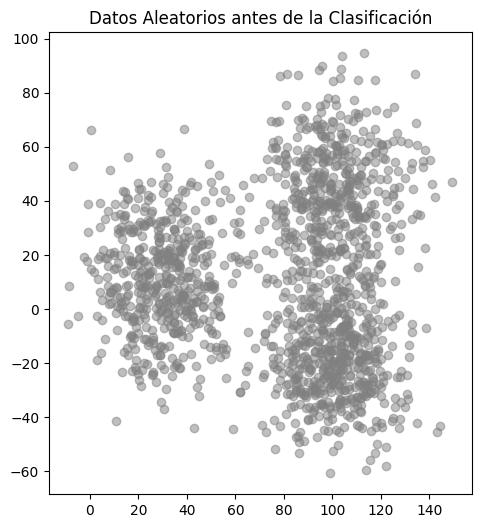

In [4]:
# Graficar datos antes de la clasificación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color='gray', alpha=0.5)
plt.title('Datos Aleatorios antes de la Clasificación')

In [5]:
def map_assign_to_centroid(data, centroids):
    assignments = []
    for point in data:
        # Calcular la distancia entre el punto y cada centroide
        distances = np.sqrt(((point - centroids) ** 2).sum(axis=1))
        # Encontrar el índice del centroide más cercano
        closest_centroid = np.argmin(distances)
        # Agregar la asignación (índice del centroide más cercano, punto)
        assignments.append((closest_centroid, point))
    return assignments

def reduce_update_centroids(assignments):
    new_centroids = []
    centroid_indices = np.unique([assignment[0] for assignment in assignments])
    for i in centroid_indices:
        # Extraer todos los puntos asignados al centroide i
        points = np.array([assignment[1] for assignment in assignments if assignment[0] == i])
        # Calcular el nuevo centroide como el promedio de esos puntos
        new_centroid = points.mean(axis=0)
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

In [6]:
# Función para ejecutar K-Means y calcular nuevos centroides

def kmeans(data, k, num_iterations=100):
    centroids = data[np.random.choice(np.arange(len(data)), k, False)]
    for _ in range(num_iterations):
        assignments = map_assign_to_centroid(data, centroids)
        centroids = reduce_update_centroids(assignments)
    return centroids, assignments

silhouette_scores = []
ks = range(2, 10)
for k in ks:
    centroids, assignments = kmeans(data, k)
    # Extraer las etiquetas de los clusters para calcular la métrica Silhouette
    labels = [centroid for centroid, point in assignments]
    score = silhouette_score(data, labels)
    silhouette_scores.append(score)


In [7]:
# Encontrar el k con la mejor métrica Silhouette
best_k = ks[np.argmax(silhouette_scores)]
print(f"Mejor k: {best_k} con una métrica Silhouette de: {max(silhouette_scores)}")

Mejor k: 3 con una métrica Silhouette de: 0.558816616764176


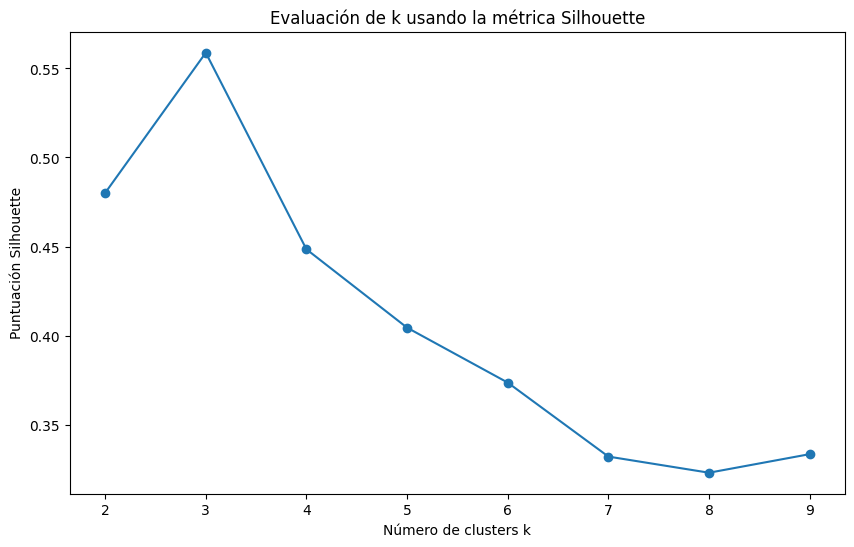

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(ks, silhouette_scores, marker='o')
plt.xlabel('Número de clusters k')
plt.ylabel('Puntuación Silhouette')
plt.title('Evaluación de k usando la métrica Silhouette')
plt.show()

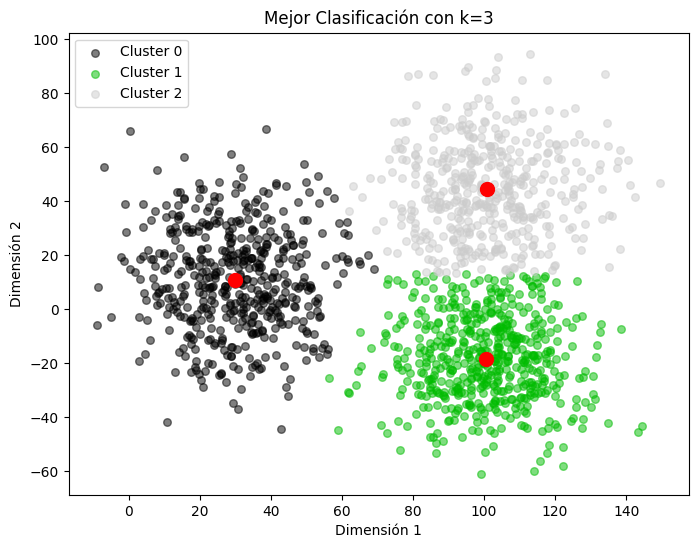

In [9]:
best_centroids, best_assignments = kmeans(data, best_k)

# Graficar el mejor clasificador
plt.figure(figsize=(8, 6))
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(best_centroids)))

# Corregimos aquí: asegurarnos de que points se convierte en un array bidimensional correctamente
for i in range(len(best_centroids)):
    points = np.array([point for centroid_index, point in best_assignments if centroid_index == i])
    if points.size > 0:  # Verificar que points contiene datos
        plt.scatter(points[:, 0], points[:, 1], s=30, color=colors[i], alpha=0.5, label=f'Cluster {i}')
        plt.scatter(best_centroids[i][0], best_centroids[i][1], color='red', marker='o', s=100)

plt.title(f'Mejor Clasificación con k={best_k}')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.legend()
plt.show()
